In [280]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import RFECV,SelectKBest,chi2
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)
df = pd.read_csv('fraudset.csv')
df.drop(df.shape[0]-1,inplace=True)
dtest = pd.read_csv('fraudTest.csv')
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654.0,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252.0,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632.0,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484526,484526,2019-07-31 00:35:07,4981132848794,fraud_Huels-Nolan,gas_transport,73.32,Joseph,Spencer,M,7854 Stephanie Island Suite 788,Holloway,OH,43985.0,40.0113,-80.9701,128.0,Child psychotherapist,1946-04-03,e07480b55b7299b82292bb10c6e33b9a,1.343695e+09,41.005217,-80.139462,0.0
484527,484527,2019-07-31 00:35:37,30407675418785,"fraud_Stroman, Hudson and Erdman",gas_transport,49.19,Danielle,Evans,F,76752 David Lodge Apt. 064,Breesport,NY,14816.0,42.1939,-76.7361,520.0,Psychotherapist,1991-10-13,4be9b9e004a84941ae17b21b914b24d8,1.343695e+09,41.390133,-77.322153,0.0
484528,484528,2019-07-31 00:36:41,38014427445058,fraud_Zboncak LLC,food_dining,106.66,Sonya,Jensen,F,4470 Jillian Courts,Adams,WI,53910.0,43.8967,-89.8219,3508.0,Sport and exercise psychologist,1946-08-11,13b17cef594d34f82944517e065cfa3e,1.343695e+09,44.833355,-89.974820,0.0
484529,484529,2019-07-31 00:38:18,3596217206093829,fraud_Paucek-Wiza,grocery_net,54.50,Sara,Ramirez,F,23843 Scott Island,Birmingham,IA,52535.0,40.8626,-91.9534,888.0,Camera operator,1988-03-25,ed8be24f2d64bd8775b39994e1f60faa,1.343695e+09,41.603506,-92.761428,0.0


### EDA

In [281]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
labelenc = LabelEncoder()
categoryvals = labelenc.fit_transform(df['category'])
gendervals = [1,2]
cityvals = labelenc.fit_transform(df['city'])
statevals = labelenc.fit_transform(df['state'])
jobvals = labelenc.fit_transform(df['job'])
firstvals = labelenc.fit_transform(df['first'])
lastvals = labelenc.fit_transform(df['last'])



jobvals = jobvals +1
categoryvals = categoryvals + 1
firstvals = firstvals +1
lastvals = lastvals +1
cityvals = cityvals + 1
statevals = statevals + 1

dictlast =  {i:j for i,j in zip(df['last'].unique(),lastvals)}
dictfirst =  {i:j for i,j in zip(df['first'].unique(),firstvals)}
dictcity =  {i:j for i,j in zip(df['city'].unique(),cityvals)}
dictstate =  {i:j for i,j in zip(df['state'].unique(),statevals)}
dictjob =  {i:j for i,j in zip(df['job'].unique(),jobvals)}
dictgen =  {i:j for i,j in zip(df['gender'].unique(),gendervals)}
dictcat =  {i:j for i,j in zip(df['category'].unique(),categoryvals)}

df['category'] = df['category'].map(dictcat)
df['gender'] = df['gender'].map(dictgen)
df['job'] = df['job'].map(dictjob)
df['city'] = df['city'].map(dictcity)
df['state'] = df['state'].map(dictstate)
df['first'] = df['first'].map(dictfirst)
df['last'] = df['last'].map(dictlast)

#df['first'] = scaler.fit_transform(df[['first']])
#df['last'] = scaler.fit_transform(df[['last']])

df['Trans_Year'] = df['trans_date_trans_time'].dt.year.astype(int)
df['Trans_Month'] = df['trans_date_trans_time'].dt.month.astype(int)
df['Trans_Day'] = df['trans_date_trans_time'].dt.day.astype(int)
df['Trans_Hour'] = df['trans_date_trans_time'].dt.hour.astype(int)
df['Trans_Minute'] = df['trans_date_trans_time'].dt.minute.astype(int)
df['Trans_Sec'] = df['trans_date_trans_time'].dt.second.astype(int)
df['Dob_Year'] = df['dob'].dt.year.astype(int)
df['Dob_Month'] = df['dob'].dt.month.astype(int)
df['Dob_Day'] = df['dob'].dt.day.astype(int)
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,Trans_Year,Trans_Month,Trans_Day,Trans_Hour,Trans_Minute,Trans_Sec,Dob_Year,Dob_Month,Dob_Day
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",9,4.97,157,19,1,561 Perry Cove,510,28,28654.0,36.0788,-81.1781,3495.0,362,1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0,2019,1,1,0,0,18,1988,3,9
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",5,107.23,301,156,1,43039 Riley Greens Suite 393,588,48,99160.0,48.8878,-118.2105,149.0,418,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,2019,1,1,0,0,44,1978,6,21
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,1,220.11,110,377,2,594 White Dale Suite 530,456,14,83252.0,42.1808,-112.2620,4154.0,300,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0,2019,1,1,0,0,51,1962,1,19
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",3,45.00,158,455,2,9443 Cynthia Court Apt. 038,84,27,59632.0,46.2306,-112.1138,1939.0,321,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0,2019,1,1,0,1,16,1967,1,12
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,10,41.96,327,148,2,408 Bradley Rest,212,46,24433.0,38.4207,-79.4629,99.0,114,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,2019,1,1,0,3,6,1986,3,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484526,484526,2019-07-31 00:35:07,4981132848794,fraud_Huels-Nolan,3,73.32,240,76,2,7854 Stephanie Island Suite 788,73,26,43985.0,40.0113,-80.9701,128.0,411,1946-04-03,e07480b55b7299b82292bb10c6e33b9a,1.343695e+09,41.005217,-80.139462,0.0,2019,7,31,0,35,7,1946,4,3
484527,484527,2019-07-31 00:35:37,30407675418785,"fraud_Stroman, Hudson and Erdman",3,49.19,90,27,1,76752 David Lodge Apt. 064,180,51,14816.0,42.1939,-76.7361,520.0,366,1991-10-13,4be9b9e004a84941ae17b21b914b24d8,1.343695e+09,41.390133,-77.322153,0.0,2019,7,31,0,35,37,1991,10,13
484528,484528,2019-07-31 00:36:41,38014427445058,fraud_Zboncak LLC,10,106.66,339,266,1,4470 Jillian Courts,54,39,53910.0,43.8967,-89.8219,3508.0,106,1946-08-11,13b17cef594d34f82944517e065cfa3e,1.343695e+09,44.833355,-89.974820,0.0,2019,7,31,0,36,41,1946,8,11
484529,484529,2019-07-31 00:38:18,3596217206093829,fraud_Paucek-Wiza,3,54.50,71,366,1,23843 Scott Island,139,39,52535.0,40.8626,-91.9534,888.0,238,1988-03-25,ed8be24f2d64bd8775b39994e1f60faa,1.343695e+09,41.603506,-92.761428,0.0,2019,7,31,0,38,18,1988,3,25


In [282]:
dtest['trans_date_trans_time'] = pd.to_datetime(dtest['trans_date_trans_time'])
dtest['dob'] = pd.to_datetime(dtest['dob'])
labelenc = LabelEncoder()
categoryvals = labelenc.fit_transform(dtest['category'])
gendervals = [1,2]
cityvals = labelenc.fit_transform(dtest['city'])
statevals = labelenc.fit_transform(dtest['state'])
jobvals = labelenc.fit_transform(dtest['job'])
firstvals = labelenc.fit_transform(dtest['first'])
lastvals = labelenc.fit_transform(dtest['last'])




jobvals = jobvals +1
firstvals = firstvals +1
lastvals= lastvals + 1
categoryvals = categoryvals + 1
cityvals = cityvals + 1
statevals = statevals + 1

dictlast =  {i:j for i,j in zip(dtest['last'].unique(),lastvals)}
dictfirst =  {i:j for i,j in zip(dtest['first'].unique(),firstvals)}
dictcity =  {i:j for i,j in zip(dtest['city'].unique(),cityvals)}
dictstate =  {i:j for i,j in zip(dtest['state'].unique(),statevals)}
dictjob =  {i:j for i,j in zip(dtest['job'].unique(),jobvals)}
dictgen =  {i:j for i,j in zip(dtest['gender'].unique(),gendervals)}
dictcat =  {i:j for i,j in zip(dtest['category'].unique(),categoryvals)}

dtest['category'] = dtest['category'].map(dictcat)
dtest['gender'] = dtest['gender'].map(dictgen)
dtest['job'] = dtest['job'].map(dictjob)
dtest['city'] = dtest['city'].map(dictcity)
dtest['state'] = dtest['state'].map(dictstate)
dtest['first'] = dtest['first'].map(dictfirst)
dtest['last'] = dtest['last'].map(dictlast)

dtest['first'] = scaler.fit_transform(dtest[['first']])
dtest['last'] = scaler.fit_transform(dtest[['last']])

dtest['Trans_Year'] = dtest['trans_date_trans_time'].dt.year.astype(int)
dtest['Trans_Month'] = dtest['trans_date_trans_time'].dt.month.astype(int)
dtest['Trans_Day'] = dtest['trans_date_trans_time'].dt.day.astype(int)
dtest['Trans_Hour'] = dtest['trans_date_trans_time'].dt.hour.astype(int)
dtest['Trans_Minute'] = dtest['trans_date_trans_time'].dt.minute.astype(int)
dtest['Trans_Sec'] = dtest['trans_date_trans_time'].dt.second.astype(int)
dtest['Dob_Year'] = dtest['dob'].dt.year.astype(int)
dtest['Dob_Month'] = dtest['dob'].dt.month.astype(int)
dtest['Dob_Day'] = dtest['dob'].dt.day.astype(int)
dtest


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,Trans_Year,Trans_Month,Trans_Day,Trans_Hour,Trans_Minute,Trans_Sec,Dob_Year,Dob_Month,Dob_Day
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,11,2.86,-0.226225,-1.030918,1,351 Darlene Green,158,40,29209,33.9659,-80.9355,333497,276,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020,6,21,12,14,25,1968,3,19
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,11,29.84,-0.098189,1.352963,2,3638 Marsh Union,17,44,84002,40.3207,-110.4360,302,393,1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2020,6,21,12,14,33,1990,1,17
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",11,41.28,-1.581272,-0.096883,2,9333 Valentine Point,62,34,11710,40.6729,-73.5365,34496,260,1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,2020,6,21,12,14,53,1970,10,21
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,6,60.05,-1.389218,1.352963,1,32941 Krystal Mill Apt. 552,765,9,32780,28.5697,-80.8191,54767,408,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,2020,6,21,12,15,15,1987,7,25
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,10,3.19,0.798063,1.352963,1,5783 Evan Roads Apt. 465,248,22,49632,44.2529,-85.0170,1126,197,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,2020,6,21,12,15,17,1955,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,11,43.77,-1.314530,1.255377,1,558 Michael Estates,750,5,63453,40.4931,-91.8912,519,461,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,2020,12,31,23,59,7,1966,2,13
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,14,111.84,1.694314,-0.034149,1,572 Davis Mountains,347,38,77566,29.0393,-95.4401,28739,120,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,2020,12,31,23,59,9,1999,12,27
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,14,86.88,0.552661,-1.700077,2,144 Evans Islands Apt. 683,97,48,99323,46.1966,-118.9017,3684,295,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,2020,12,31,23,59,15,1981,11,29
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,10,7.99,-1.751986,1.039294,1,7020 Doyle Stream Apt. 951,821,12,83643,44.6255,-116.4493,129,219,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,2020,12,31,23,59,24,1965,12,15


In [283]:
print('Shape of trainset: ',df.shape)
smote = SMOTE(sampling_strategy = 0.07,random_state=42)
down_sample = RandomUnderSampler(sampling_strategy = {0:200000},random_state=42)
up_sample = RandomOverSampler(sampling_strategy = 0.07,random_state=42)
zero = df[df['is_fraud']==0]  #Used later
one = df[df['is_fraud']==1]  #Used later

ytrain = df['is_fraud']
ytest = dtest['is_fraud']
df.drop(columns=['Unnamed: 0','first','last','is_fraud','merchant','trans_num','street','trans_date_trans_time','dob','cc_num'],axis=1,inplace=True)
dtest.drop(columns=['Unnamed: 0','first','last','is_fraud','merchant','trans_num','street','trans_date_trans_time','dob','cc_num'],axis=1,inplace=True)
df = df.loc[:,['amt','Trans_Hour','category','unix_time','Dob_Year','city_pop','lat','zip','long','merch_lat','merch_long']]
dtest = dtest.loc[:,['amt','Trans_Hour','category','unix_time','Dob_Year','city_pop','lat','zip','long','merch_lat','merch_long']]

temp = df['long']
temp1 = df['merch_long']
temp2 = dtest['long']
temp3 = dtest['merch_long']
df.drop(columns = ['long','merch_long'],inplace=True)
dtest.drop(columns = ['long','merch_long'],inplace=True)
k_best = SelectKBest(score_func=chi2, k=9)
X_new = k_best.fit_transform(df,ytrain)
selected_indices = k_best.get_support(indices=True)

# Get the names of the selected features
selected_features = df.columns[selected_indices]
df['long'] = temp
df['merch_long'] = temp1
dtest['long'] = temp2
dtest['merch_long'] = temp3

Shape of trainset:  (484531, 32)


In [284]:


scaler = StandardScaler()
df['unix_time'] = scaler.fit_transform(df[['unix_time']])
df['amt'] = scaler.fit_transform(df[['amt']])
df['zip'] = scaler.fit_transform(df[['zip']])
df['long'] = scaler.fit_transform(df[['long']])
df['lat'] = scaler.fit_transform(df[['lat']])
df['merch_lat'] = scaler.fit_transform(df[['merch_lat']])
df['merch_long'] = scaler.fit_transform(df[['merch_long']])
df['city_pop'] = scaler.fit_transform(df[['city_pop']])


dtest['unix_time'] = scaler.fit_transform(dtest[['unix_time']])
dtest['amt'] = scaler.fit_transform(dtest[['amt']])
dtest['zip'] = scaler.fit_transform(dtest[['zip']])
dtest['long'] = scaler.fit_transform(dtest[['long']])
dtest['lat'] = scaler.fit_transform(dtest[['lat']])
dtest['merch_lat'] = scaler.fit_transform(dtest[['merch_lat']])
dtest['merch_long'] = scaler.fit_transform(dtest[['merch_long']])
dtest['city_pop'] = scaler.fit_transform(dtest[['city_pop']])

df

,amt,Trans_Hour,category,unix_time,Dob_Year,city_pop,lat,zip,merch_lat,long,merch_long
0,-0.410266,0,9,-1.944932,1988,-0.282692,-0.484217,-0.746938,-0.494078,0.655739,0.591987
1,0.229904,0,5,-1.944927,1978,-0.293718,2.040246,1.872955,2.079991,-2.035318,-2.031747
2,0.936558,0,1,-1.944926,1962,-0.280521,0.718396,1.281839,0.903677,-1.603054,-1.593808
3,-0.159669,0,3,-1.944921,1967,-0.287820,1.516551,0.404156,1.664014,-1.592285,-1.623328
4,-0.178700,0,10,-1.944900,1986,-0.293883,-0.022663,-0.903784,0.027423,0.780379,0.839988
...,...,...,...,...,...,...,...,...,...,...,...
484526,0.017620,0,3,1.581405,1946,-0.293787,0.290820,-0.177262,0.483633,0.670854,0.730576
484527,-0.133439,0,3,1.581411,1991,-0.292495,0.720978,-1.261137,0.558992,0.978529,0.935120
484528,0.226336,0,10,1.581423,1946,-0.282650,1.056575,0.191536,1.233106,0.027615,0.016500
484529,-0.100197,0,3,1.581442,1988,-0.291283,0.458599,0.140443,0.600766,-0.127276,-0.185816


### Downsampling

In [285]:

df,ytrain = down_sample.fit_resample(df,ytrain)
df = pd.DataFrame(df, columns=df.columns)
ytrain = pd.Series(ytrain, name='is_fraud')
print('Shape after downsampling: ',df.shape)

Shape after downsampling:  (202986, 11)


### Oversampling (Don't Run (Just for implementation purposes))

In [161]:
df,ytrain = up_sample.fit_resample(df,ytrain)
df = pd.DataFrame(df, columns=df.columns)
ytrain = pd.Series(ytrain, name='is_fraud')
print('Shape after upsampling: ',df.shape)

(181900, 11)

### SMOTE

In [286]:
df,ytrain = smote.fit_resample(df,ytrain)
df = pd.DataFrame(df, columns=df.columns)
ytrain = pd.Series(ytrain, name='is_fraud')
print('Shape after SMOTE: ',df.shape)

Shape after SMOTE:  (214000, 11)


### Best Results for balancing dataset: SMOTE & UnderSample

## Random forest classifier


In [292]:
clf = RandomForestClassifier(n_estimators = 100,random_state=42,max_depth = 8)
clf.fit(df,ytrain)

pred=clf.predict_proba(dtest)
pred = pred[:,1]
pred = pred>0.61
totalp = pred.sum()
print('Test Set')
print("Accuracy",accuracy_score(ytest,pred))
print("F1:",f1_score(ytest,pred))
precision = precision_score(ytest,pred)
recall = recall_score(ytest,pred)

print("Precision:", precision)
print("Recall:", recall)
matrix = confusion_matrix(ytest,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])
print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytest.sum())
print("Total 0s",len(ytest) - ytest.sum())

pred=clf.predict_proba(df)
pred = pred[:,1]
pred = pred>0.61

print('Train Set')
totalp = pred.sum()

print("Accuracy",accuracy_score(ytrain,pred))
print("F1:",f1_score(ytrain,pred))
print("Precision:",precision_score(ytrain,pred))
print("Recall:", recall_score(ytrain,pred))
matrix = confusion_matrix(ytrain,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])

print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytrain.sum())
print("Total 0s",len(ytrain) - ytrain.sum())

Test Set
Accuracy 0.9968257338690957
F1: 0.5841584158415842
Precision: 0.5908440629470673
Recall: 0.5776223776223777
True positives 1239
False positives 858
True negatives 552716
False negatives 906
Pred. Total 1s 2097
Pred. Total 0s 553622
Total 1s 2145
Total 0s 553574
Train Set
Accuracy 0.9772102803738317
F1: 0.7907316026603733
Precision: 0.9902203116603976
Recall: 0.6581428571428571
True positives 9214
False positives 91
True negatives 199909
False negatives 4786
Pred. Total 1s 9305
Pred. Total 0s 204695
Total 1s 14000.0
Total 0s 200000.0


## XGBoost

In [293]:
xgbmodel = xgb.XGBRegressor(max_depth= 8, n_estimators= 100,random_state=42)

# Fitting the model
xgbmodel.fit(df,ytrain)

pred = xgbmodel.predict(dtest)

pred = (pred>0.61)
totalp = pred.sum()
print('Test Set')
print("Accuracy",accuracy_score(ytest,pred))
print("F1:",f1_score(ytest,pred))
precision = precision_score(ytest,pred)
recall = recall_score(ytest,pred)

print("Precision:", precision)
print("Recall:", recall)
matrix = confusion_matrix(ytest,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])
print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytest.sum())
print("Total 0s",len(ytest) - ytest.sum())

print('Train Set')
pred = xgbmodel.predict(df)
pred = pred>0.61
totalp = (pred==1).sum()

print("Accuracy",accuracy_score(ytrain,pred))
print("F1:",f1_score(ytrain,pred))
print("Precision:",precision_score(ytrain,pred))
print("Recall:", recall_score(ytrain,pred))
matrix = confusion_matrix(ytrain,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])

print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytrain.sum())
print("Total 0s",len(ytrain) - ytrain.sum())

Test Set
Accuracy 0.8504316030223908
F1: 0.028700306167761234
Precision: 0.014719102470364022
Recall: 0.5724941724941724
True positives 1228
False positives 82201
True negatives 471373
False negatives 917
Pred. Total 1s 83429
Pred. Total 0s 472290
Total 1s 2145
Total 0s 553574
Train Set
Accuracy 0.9943177570093458
F1: 0.9547820913282762
Precision: 0.9958113558796152
Recall: 0.917
True positives 12838
False positives 54
True negatives 199946
False negatives 1162
Pred. Total 1s 12892
Pred. Total 0s 201108
Total 1s 14000.0
Total 0s 200000.0


## Neural Network

In [294]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Train the model
model.fit(df,ytrain, epochs=10, batch_size=32, validation_split=0.1)

pred = model.predict(dtest)
pred = (pred>0.5)
totalp = pred.sum()
print('Test Set')
print("Accuracy",accuracy_score(ytest,pred))
print("F1:",f1_score(ytest,pred))
precision = precision_score(ytest,pred)
recall = recall_score(ytest,pred)

print("Precision:", precision)
print("Recall:", recall)
matrix = confusion_matrix(ytest,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])
print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytest.sum())
print("Total 0s",len(ytest) - ytest.sum())

print('Train Set')
pred = model.predict(df)
pred = pred>0.5
totalp = (pred==1).sum()

print("Accuracy",accuracy_score(ytrain,pred))
print("F1:",f1_score(ytrain,pred))
print("Precision:",precision_score(ytrain,pred))
print("Recall:", recall_score(ytrain,pred))
matrix = confusion_matrix(ytrain,pred)
print("True positives",matrix[1][1])
print("False positives",matrix[0][1])
print("True negatives",matrix[0][0])
print("False negatives",matrix[1][0])

print("Pred. Total 1s",totalp)
print("Pred. Total 0s",len(pred) - totalp)
print("Total 1s",ytrain.sum())
print("Total 0s",len(ytrain) - ytrain.sum())

Epoch 1/10
6019/6019 [==============================] - 20s 2ms/step - loss: 0.0450 - accuracy: 0.9995 - val_loss: 691.2086 - val_accuracy: 0.3458
Epoch 2/10
6019/6019 [==============================] - 8s 1ms/step - loss: 1.5606e-22 - accuracy: 1.0000 - val_loss: 691.2086 - val_accuracy: 0.3458
Epoch 3/10
6019/6019 [==============================] - 8s 1ms/step - loss: 6.8237e-27 - accuracy: 1.0000 - val_loss: 691.2086 - val_accuracy: 0.3458
Epoch 4/10
6019/6019 [==============================] - 9s 2ms/step - loss: 7.9827e-35 - accuracy: 1.0000 - val_loss: 691.2086 - val_accuracy: 0.3458
Epoch 5/10
6019/6019 [==============================] - 9s 1ms/step - loss: 4.9112e-05 - accuracy: 1.0000 - val_loss: 807.6842 - val_accuracy: 0.3458
Epoch 6/10
6019/6019 [==============================] - 8s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 807.6842 - val_accuracy: 0.3458
Epoch 7/10
6019/6019 [==============================] - 8s 1ms/step - loss: 0.0000e+00 - accuracy: 1.00

C:\Users\Saim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
True positives 0
False positives 0
True negatives 553574
False negatives 2145
Pred. Total 1s 0
Pred. Total 0s 555719
Total 1s 2145
Total 0s 553574
Train Set
6688/6688 [==============================] - 6s 832us/step
Accuracy 0.9345794392523364
F1: 0.0
Precision: 0.0


C:\Users\Saim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.0
True positives 0
False positives 0
True negatives 200000
False negatives 14000
Pred. Total 1s 0
Pred. Total 0s 214000
Total 1s 14000.0
Total 0s 200000.0


# End Analysis

### XGBoost

The XGboost would overfit to the training set if the depth is increased, however reducing the depth would
cause it to misbehave on the training data but slightly improve the test set f1 scores.  

### NeuralNetwork

The Neural Network given such an imbalanced dataset would not work as required even with tuning the
hyper-parameters to the utmost would not give desired results and training a neural network often causes
it to stop improving accuracy on such an imbalanced dataset.

### Random-Forest

The Random Forest algorithm is working the best in this scenario as by tuning the hyper-parameters 
and making the imbalanced data a little more balanced can cause the Random-Forest the learn the pattern
between fraud cases and non-fraud cases much better than the XGBoost and NeuralNetwork

##### Best results achieved with Random-Forest

Test Set
Accuracy 0.9968257338690957
F1: 0.5841584158415842
Precision: 0.5908440629470673
Recall: 0.5776223776223777
Train Set
Accuracy 0.9943177570093458
F1: 0.9547820913282762
Precision: 0.9958113558796152
Recall: 0.6581428571428571

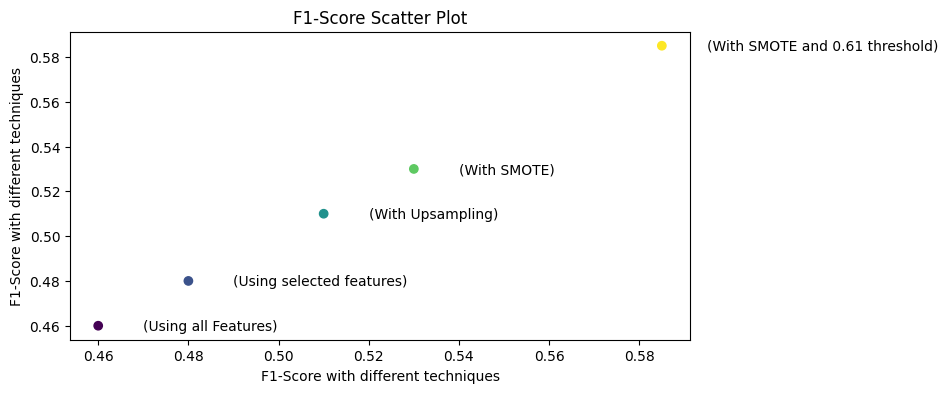

In [351]:
x = [0.46,0.48,0.51,0.53,0.585]
labels = ['Using all Features','Using selected features','With Upsampling','With SMOTE','With SMOTE and 0.61 threshold']
plt.figure(figsize=(8, 4)) 
plt.scatter(x,x,c=[1,2,3,4,5])
for (i, j,label) in zip(x, x,labels):
    plt.text(i+ 0.01, j-0.002,f'({label})',ha='left')

#for i, label in enumerate(labels):
    #plt.text(i,x[i], label)

# Customize the plot (optional)
plt.title('F1-Score Scatter Plot')
plt.xlabel('F1-Score with different techniques')
plt.ylabel('F1-Score with different techniques')
# Display the plot
plt.show()

# Feature Selection Process

This process used the KBest selection technique from sklearn, feature-importances from XGBoost
and Random-Forest and checking info manually about those features to get insights about differentiation
between frauds and non-frauds of each feature.

In [295]:
print('K-best Feature selection: ',selected_features)

K-best Feature selection:  Index(['amt', 'Trans_Hour', 'category', 'unix_time', 'Dob_Year', 'city_pop',
       'lat', 'zip', 'merch_lat'],
      dtype='object')


In [296]:
features = clf.feature_importances_.argsort()[::-1]
print('Random-Forest Feature selection',df.columns[features])

Random-Forest Feature selection Index(['amt', 'Trans_Hour', 'category', 'Dob_Year', 'unix_time', 'city_pop',
       'zip', 'lat', 'long', 'merch_lat', 'merch_long'],
      dtype='object')


In [297]:
print("XGB feature selection")
feature_importance = xgbmodel.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]
top_n_features = df.columns[sorted_idx[:12]]
print("Top 12 features with XGB: ",top_n_features)


XGB feature selection
Top 12 features with XGB:  Index(['category', 'amt', 'Trans_Hour', 'Dob_Year', 'city_pop', 'zip', 'lat',
       'long', 'unix_time', 'merch_lat', 'merch_long'],
      dtype='object')


In [298]:
print(one['amt'].describe())
print(zero['amt'].describe())

count    2986.000000
mean      520.090971
std       396.734750
min         1.180000
25%       117.107500
50%       357.235000
75%       900.335000
max      1334.070000
Name: amt, dtype: float64
count    481545.000000
mean         67.717508
std         153.094566
min           1.000000
25%           9.610000
50%          47.280000
75%          82.600000
max       25086.940000
Name: amt, dtype: float64


In [299]:
print(one['state'].describe())
print(zero['state'].describe())

count    2986.000000
mean       31.325519
std        13.744932
min         2.000000
25%        17.000000
50%        32.000000
75%        43.000000
max        51.000000
Name: state, dtype: float64
count    481545.000000
mean         31.339129
std          13.218485
min           2.000000
25%          17.000000
50%          32.000000
75%          43.000000
max          51.000000
Name: state, dtype: float64


In [300]:
print(one['city'].describe())
print(zero['city'].describe())

count    2986.000000
mean      423.628935
std       256.984508
min         2.000000
25%       192.000000
50%       412.000000
75%       635.000000
max       859.000000
Name: city, dtype: float64
count    481545.000000
mean        406.156079
std         250.829255
min           2.000000
25%         182.000000
50%         392.000000
75%         619.000000
max         859.000000
Name: city, dtype: float64


In [301]:
print(one['Trans_Hour'].describe())
print(zero['Trans_Hour'].describe())

count    2986.000000
mean       13.854990
std         9.729821
min         0.000000
25%         2.000000
50%        22.000000
75%        23.000000
max        23.000000
Name: Trans_Hour, dtype: float64
count    481545.000000
mean         12.795980
std           6.792996
min           0.000000
25%           7.000000
50%          14.000000
75%          19.000000
max          23.000000
Name: Trans_Hour, dtype: float64


In [302]:
print(one['merch_lat'].describe())
print(zero['merch_lat'].describe())

count    2986.000000
mean       38.939333
std         5.493546
min        25.118898
25%        35.176559
50%        39.668366
75%        42.185024
max        67.510267
Name: merch_lat, dtype: float64
count    481545.000000
mean         38.532422
std           5.105200
min          19.029798
25%          34.734330
50%          39.360833
75%          41.952995
max          66.659242
Name: merch_lat, dtype: float64


In [303]:
print(one['merch_long'].describe())
print(zero['merch_long'].describe())

count    2986.000000
mean      -89.731069
std        14.755165
min      -166.550779
25%       -96.115354
50%       -86.725115
75%       -79.504808
max       -68.677043
Name: merch_long, dtype: float64
count    481545.000000
mean        -90.205004
std          13.767227
min        -166.671242
25%         -96.875200
50%         -87.408292
75%         -80.209259
max         -66.956540
Name: merch_long, dtype: float64


In [304]:
print(one['city_pop'].describe())
print(zero['city_pop'].describe())

count    2.986000e+03
mean     9.270335e+04
std      2.789682e+05
min      3.700000e+01
25%      6.020000e+02
50%      2.379000e+03
75%      2.484000e+04
max      2.906700e+06
Name: city_pop, dtype: float64
count    4.815450e+05
mean     8.926458e+04
std      3.036237e+05
min      2.300000e+01
25%      7.430000e+02
50%      2.456000e+03
75%      2.047800e+04
max      2.906700e+06
Name: city_pop, dtype: float64


In [305]:
print(one['category'].describe())
print(zero['category'].describe())

count    2986.000000
mean        5.067314
std         2.371909
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max        12.000000
Name: category, dtype: float64
count    481545.000000
mean          5.253885
std           2.772725
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max          12.000000
Name: category, dtype: float64


In [306]:
print(one['long'].describe())
print(zero['long'].describe())

count    2986.000000
mean      -89.729062
std        14.738374
min      -165.672300
25%       -95.651500
50%       -86.665550
75%       -79.767800
max       -69.482800
Name: long, dtype: float64
count    481545.000000
mean        -90.204846
std          13.754989
min        -165.672300
25%         -96.790900
50%         -87.458100
75%         -80.138100
max         -67.950300
Name: long, dtype: float64


In [307]:
print(one['lat'].describe())
print(zero['lat'].describe())

count    2986.000000
mean       38.942358
std         5.458965
min        26.118400
25%        35.150600
50%        39.706050
75%        42.266500
max        66.693300
Name: lat, dtype: float64
count    481545.000000
mean         38.533170
std           5.071383
min          20.027100
25%          34.668900
50%          39.354300
75%          41.894800
max          65.689900
Name: lat, dtype: float64


In [308]:
print(one['unix_time'].describe())
print(zero['unix_time'].describe())

count    2.986000e+03
mean     1.333807e+09
std      5.240656e+06
min      1.325466e+09
25%      1.329172e+09
50%      1.333145e+09
75%      1.337988e+09
max      1.343614e+09
Name: unix_time, dtype: float64
count    4.815450e+05
mean     1.335490e+09
std      5.192922e+06
min      1.325376e+09
25%      1.331306e+09
50%      1.335900e+09
75%      1.339958e+09
max      1.343695e+09
Name: unix_time, dtype: float64


In [309]:
print(one['zip'].describe())
print(zero['zip'].describe())

count     2986.000000
mean     47211.639652
std      27048.499796
min       1535.000000
25%      23666.000000
50%      45758.500000
75%      68869.000000
max      99783.000000
Name: zip, dtype: float64
count    481545.000000
mean      48765.011251
std       26910.710671
min        1257.000000
25%       26041.000000
50%       48154.000000
75%       72011.000000
max       99783.000000
Name: zip, dtype: float64


In [310]:
print(one['Dob_Year'].describe())
print(zero['Dob_Year'].describe())

count    2986.000000
mean     1971.006363
std        19.219641
min      1925.000000
25%      1959.000000
50%      1972.000000
75%      1987.000000
max      2005.000000
Name: Dob_Year, dtype: float64
count    481545.000000
mean       1973.216300
std          17.342043
min        1924.000000
25%        1962.000000
50%        1975.000000
75%        1987.000000
max        2005.000000
Name: Dob_Year, dtype: float64
